In [4]:
import numpy as np
import cv2
import math
import pyautogui

In [35]:
cv2.rectangle?

In [90]:
# 카메라 켜기
capture = cv2.VideoCapture(0)

while capture.isOpened():
    
    # 캡쳐화면 메모리에 넣기
    ret,frame = capture.read()
    frame = cv2.flip(frame,1)
    
    # 손 데이터 박스
    cv2.rectangle(frame, (400,200),(600,400),(0,255,0),0)
    crop_image = frame[200:400,400:600]
    
    # 가우시안블러적용
    blur = cv2.GaussianBlur(crop_image, (3,3),0)
    
    # BGR -> HSV로 변경
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
    
    # 피부색은 하얀색 나머지는 검정색으로 변환하는 이진 이미지 생성
#     mask2 = cv2.inRange(hsv, np.array([2,0,0]), np.array([20,255,255]))
    #빨간색 인지
    mask2 = cv2.inRange(hsv,np.array([0,50,50]),np.array([10,255,255]))
    
    # 모폴로지 변형 필터
    kernel = np.ones((5,5))
    
    # 모폴로지 필터 적용(침식,팽창 적용)
    dilation = cv2.dilate(mask2,kernel, iterations=1)
    erosion = cv2.erode(dilation, kernel, iterations=1)
    
    # 가우시안 블러와 threshhold 적용
    filtered = cv2.GaussianBlur(erosion, (3,3),0)
    ret, thresh = cv2.threshold(filtered, 127,255,0)
    
    # contour 찾기
    contours, hierachy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    try:
        # 최대 영역으로 contour 찾기
        contour = max(contours, key=lambda x: cv2.contourArea(x))
        
        # contour주변의 바운딩 박스 만들기
        x,y,w,h = cv2.boundingRect(contour)
        cv2.rectangle(crop_image, (x,y),(x+w,y+h), (0,0,255),0)
        
        # convex hull
        hull = cv2.convexHull(contour)
        
        # contour 그리기
        drawing = np.zeros(crop_image.shape,np.uint8)
        cv2.drawContours(drawing,[contour],-1,(0,255,0),0)
        cv2.drawContours(drawing,[hull], -1, (0,0,255),0)
        
        # Fi convexity defects
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour,hull)
        
        count_defects = 0
        
        for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            start = tuple(contour[s][0])
            end = tuple(contour[e][0])
            far = tuple(contour[f][0])
            
            a = math.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)
            b = math.sqrt((far[0] - start[0])**2 + (far[1] - start[1])**2)
            c = math.sqrt((end[0] - far[0])**2 + (end[1] - far[1])**2)
            angle = (math.acos((b**2 + c**2 - a**2)/(2*b*c))*180)/3.14
            
            if angle <= 90:
                count_defects += 1
                cv2.circle(crop_image, far, 1,[0,255,0],2)
                
            cv2.line(crop_image,start, end, [0,255,0],2)
            
        # 조건에 맞다면 스페이스바 눌러라
        if count_defects >= 4:
            pyautogui.press('space')
            cv2.putText(frame, "JUMP",(420,80), cv2.FONT_HERSHEY_SIMPLEX,2,2,2)
            
    except:
        pass
    
    # 이미지 보여주기
    cv2.imshow("Gesture",frame)
    
    # q 누르면 카메라 끄기
    if cv2.waitKey(1) == ord('q'):
        break
        

capture.release()
cv2.destroyAllWindows()

In [64]:
cv2.putText?

In [28]:
# 시도했지만 이것도 역시나 컬러디텍션으로 하는 거라 자꾸 뒤에 침대를 인식함
# 빨간색으로 하는게 차라리 나을듯,,,
# 빨간색으로 헀는데 오히력 인식이 잘됨(집에 나무색이 많아서 그런가)

In [81]:
image = cv2.imread('image.jpg')

In [56]:
crop = image[200:400,400:600]
blur = cv2.GaussianBlur(crop_image, (3,3),0)
hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)

In [57]:
import matplotlib.pyplot as plt

In [58]:
mask2 = cv2.inRange(hsv, np.array([2,0,0]), np.array([20,255,255]))

In [83]:
txt = cv2.putText(image, "JUMP",(420,180), cv2.FONT_HERSHEY_SIMPLEX,2,2,2)

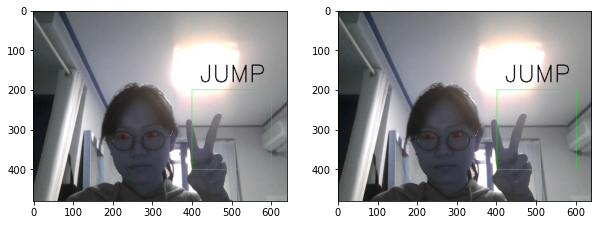

In [84]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(txt, cmap='gray')
plt.show()

In [82]:
rec = cv2.rectangle(image, (400,200),(600,400),(0,255,0),0)

In [ ]:
# 손가락 인식 mediapipe

- 손 움직임에 따른 서로 간격 관계만 파악하면 다양한 손가락 동작 인식할 수 있을듯 posedetection 도 사용가능
https://google.github.io/mediapipe/solutions/hands.html
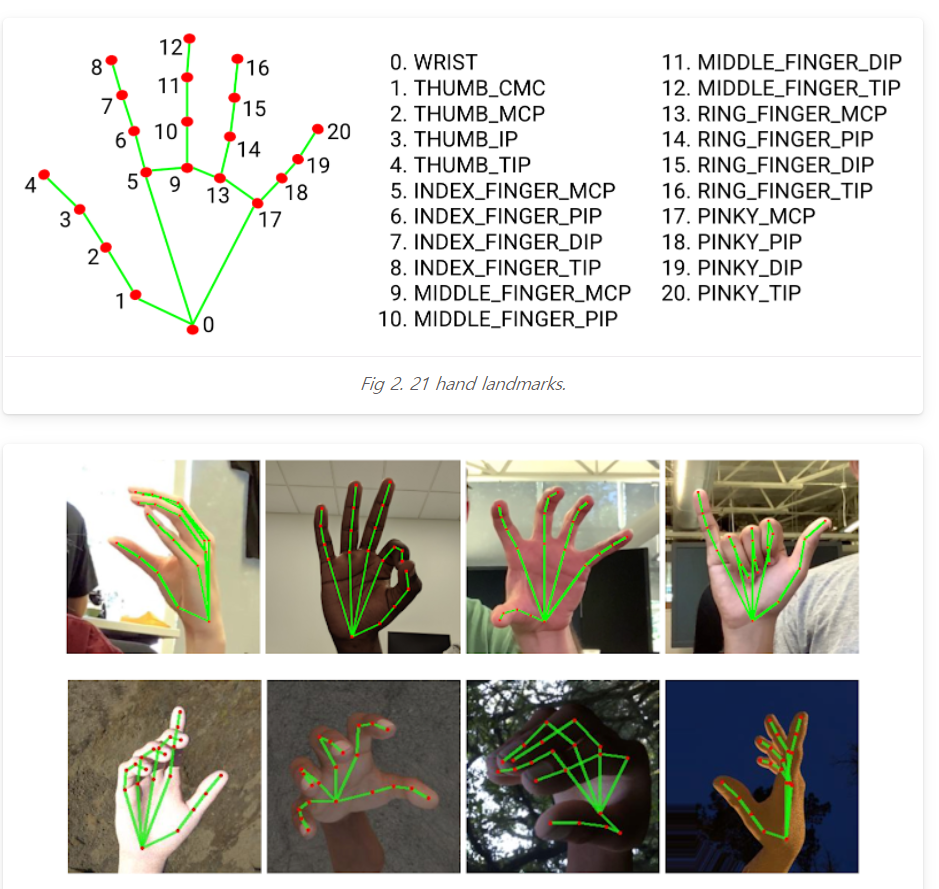

In [88]:
import cv2
import mediapipe as mp
from dynamikontrol import Module













In [96]:
# 관절그리는 도구
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# 웹캠 켜기
cap = cv2.VideoCapture(0)

# module = Module()

with mp_hands.Hands( #손가락 인식 모델 초기화
    max_num_hands = 1, # 최대 몇개의 손을 인식할건지
    min_detection_confidence = 0.5,
    min_tracking_confidence = 0.5) as hands:
    
    while cap.isOpened():
        success, image = cap.read()
        if not success: # 성공하지 못하면 다음 프레임으로
            continue
            
        # 성공하면 밑에꺼 실행
        image = cv2.cvtColor(cv2.flip(image,1),cv2.COLOR_BGR2RGB) # mediapipe는 rgb를 사용함
        result = hands.process(image)
        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # cv로 출력해야하므로 다시 bgr로 바꿔줌
        
        if result.multi_hand_landmarks: # 손이 인식되면 밑 코드가 실행됨
            for hand_landmarks in result.multi_hand_landmarks: # 여러개 손이 동시에 검출될 경우 하나씩 불러와서 처리
                thumb = hand_landmarks.landmark[4] # 엄지손가락 인덱스 4 / 손가락 좌표(x,y)를 불러옴
                index = hand_landmarks.landmark[8] # 검지손가락 인덱스가 8번
                
                diff = abs(index.x - thumb.x) # 좌표의 값의 (0~1) 이므로 차도 1이하임
                
                volume = int(diff*500)
                
#                 module.motor.angle(volume) # 각도 제어
                # 엄지 검지 간격이 작으면 0에 가까워져서 모터의 각도가 0에 가까워짐
                # 간격 커지면 모터 각도도 커짐
                
                cv2.putText(
                    image, text = 'Volume: %d' %volume, org=(10,30),
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1,
                    color = 255, thickness=2)
                
                mp_drawing.draw_landmarks(
                    image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
            if volume >= 100:
                pyautogui.press('space')
                cv2.putText(image, "JUMP",(420,80), cv2.FONT_HERSHEY_SIMPLEX,2,2,2)
            
        cv2.imshow('image',image)
        if cv2.waitKey(1) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
